In [ ]:
import requests
from conllu import parse
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel, AutoModelForMaskedLM, AutoModel
from transformers import GPT2Tokenizer, GPT2Model
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
import torch.nn.functional as F

c:\ProgramData\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Attention Head Probing

In [ ]:
urls = {
    "dev": "https://raw.githubusercontent.com/UniversalDependencies/UD_Turkish-BOUN/refs/heads/master/tr_boun-ud-dev.conllu",
    "test": "https://raw.githubusercontent.com/UniversalDependencies/UD_Turkish-BOUN/refs/heads/master/tr_boun-ud-test.conllu",
    "train": "https://raw.githubusercontent.com/UniversalDependencies/UD_Turkish-BOUN/refs/heads/master/tr_boun-ud-train.conllu",
    "dev2": "https://raw.githubusercontent.com/UniversalDependencies/UD_Turkish-Atis/refs/heads/master/tr_atis-ud-dev.conllu",
    "test2": "https://raw.githubusercontent.com/UniversalDependencies/UD_Turkish-Atis/refs/heads/master/tr_atis-ud-test.conllu",
    "train2": "https://raw.githubusercontent.com/UniversalDependencies/UD_Turkish-Atis/refs/heads/master/tr_atis-ud-train.conllu",
    "test3": "https://raw.githubusercontent.com/UniversalDependencies/UD_Turkish-GB/refs/heads/master/tr_gb-ud-test.conllu",
    "dev4": "https://raw.githubusercontent.com/UniversalDependencies/UD_Turkish-Kenet/refs/heads/master/tr_kenet-ud-dev.conllu",
    "test4": "https://raw.githubusercontent.com/UniversalDependencies/UD_Turkish-Kenet/refs/heads/master/tr_kenet-ud-test.conllu",
    "train4": "https://raw.githubusercontent.com/UniversalDependencies/UD_Turkish-Kenet/refs/heads/master/tr_kenet-ud-train.conllu"
}

def fetch_and_parse(url):
    response = requests.get(url)
    response.raise_for_status()
    return parse(response.text)

filtered = []
for name, url in urls.items():
    sentences = fetch_and_parse(url)
    for sent in sentences:
        nsubj_tokens = [tok for tok in sent if tok["deprel"] == "nsubj"]
        root_tokens = [tok for tok in sent if tok["deprel"] == "root"]
        if nsubj_tokens and root_tokens:
            filtered.append({
                "sentence": " ".join(tok["form"] for tok in sent),
                "nsubj": [tok["form"] for tok in nsubj_tokens],
                "root": [tok["form"] for tok in root_tokens],
                "split": name
            })


df = pd.DataFrame(filtered)
df.to_csv("nsubj_root_sentences_tr.csv", index=False, encoding='utf-8')

In [ ]:
# Read the CoNLL-U file
with open("tur_tr_web_2015_1M.conllu", "r", encoding="utf-8") as file:
    data = file.read()

# Parse the file content
parsed_sentences = parse(data)

# Print the first sentence
print(parsed_sentences[0])

NameError: name 'parse' is not defined

In [ ]:
model_name = "dbmdz/bert-base-turkish-128k-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_attentions=True)
model.eval()

df = pd.read_csv("nsubj_root_sentences_tr.csv")

results = []

for i, row in df.iterrows():
    sentence = row["sentence"]
    nsubj = row["nsubj"].strip("[]'").split(",")[0].strip()
    root = row["root"].strip("[]'").split(",")[0].strip()

    inputs = tokenizer(sentence, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    try:
        nsubj_idx = tokens.index(nsubj)
        root_idx = tokens.index(root)
    except ValueError:
        continue

    if root_idx < nsubj_idx:
        continue

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    attentions = outputs.attentions
    attn_tensor = torch.stack(attentions).squeeze(1)
    attention_scores = attn_tensor[:, :, root_idx, nsubj_idx]

    flat_idx = torch.argmax(attention_scores)
    best_layer = flat_idx.item() // attention_scores.shape[1]
    best_head = flat_idx.item() % attention_scores.shape[1]
    max_value = attention_scores[best_layer, best_head].item()

    results.append({
        "sentence": sentence,
        "nsubj": nsubj,
        "root": root,
        "nsubj_idx": nsubj_idx,
        "root_idx": root_idx,
        "best_layer": best_layer,
        "best_head": best_head,
        "attention_value": max_value
    })

pd.DataFrame(results).to_csv("turkish_bert_attention_nsubj_root.csv", index=False)


KeyboardInterrupt: 

In [ ]:
model_name = "redrussianarmy/gpt2-turkish-cased"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = GPT2Model.from_pretrained(model_name, output_attentions=True)
model.eval()

df = pd.read_csv("nsubj_root_sentences_tr.csv")

results = []

for i, row in df.iterrows():
    sentence = row["sentence"]
    nsubj = row["nsubj"].strip("[]'").split(",")[0].strip()
    root = row["root"].strip("[]'").split(",")[0].strip()

    inputs = tokenizer(sentence, return_tensors="pt", padding=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    try:
        root_idxs = [i for i, tok in enumerate(tokens) if root in tok]
        nsubj_idxs = [i for i, tok in enumerate(tokens) if nsubj in tok]
        if not root_idxs or not nsubj_idxs:
            continue
        root_idx = root_idxs[0]
        nsubj_idx = nsubj_idxs[0]
        if nsubj_idx >= root_idx:
            continue
    except Exception:
        continue

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    attentions = outputs.attentions
    attn_tensor = torch.stack(attentions).squeeze(1)

    attention_scores = attn_tensor[:, :, root_idx, nsubj_idx]

    flat_idx = torch.argmax(attention_scores)
    best_layer = flat_idx.item() // attention_scores.shape[1]
    best_head = flat_idx.item() % attention_scores.shape[1]
    max_value = attention_scores[best_layer, best_head].item()

    results.append({
        "sentence": sentence,
        "nsubj": nsubj,
        "root": root,
        "root_idx": root_idx,
        "nsubj_idx": nsubj_idx,
        "best_layer": best_layer,
        "best_head": best_head,
        "attention_value": max_value
    })

pd.DataFrame(results).to_csv("gpt2_turkish_attention_nsubj_root.csv", index=False)


In [ ]:
def summarize_attention_weight(csv_path):
    df = pd.read_csv(csv_path)
    total_sentences = len(df)

    weighted_scores = (
        df.groupby(["best_layer", "best_head"])["attention_value"]
        .sum()
        .reset_index()
        .rename(columns={"attention_value": "total_weighted_attention"})
    )

    frequency = (
        df.groupby(["best_layer", "best_head"])
        .size()
        .reset_index(name="count")
    )

    summary = weighted_scores.merge(frequency, on=["best_layer", "best_head"])
    summary["percentage"] = 100 * summary["count"] / total_sentences

    top5 = summary.sort_values("total_weighted_attention", ascending=False).head(5)
    return top5


def summarize_attention_frequency(csv_path):
    df = pd.read_csv(csv_path)
    total = len(df)

    freq_table = (
        df.groupby(["best_layer", "best_head"])
        .size()
        .reset_index(name="count")
        .sort_values("count", ascending=False)
    )
    freq_table["percentage"] = 100 * freq_table["count"] / total

    return freq_table.head(5)

def get_top_layer_head(df, myrow="total_weighted_attention"):
    top_row = df.loc[df[myrow].idxmax()]
    LAYER = int(top_row["layer"])
    HEAD = int(top_row["head"])
    return LAYER, HEAD


In [ ]:
gpt2_voita_head_accuracy_df = pd.read_csv("./Transformers/results/gpt2_voita_head_accuracy_full.csv")

top_5_gpt = gpt2_voita_head_accuracy_df.nlargest(5, 'accuracy')

print(top_5_gpt)

GPT2_LAYER, GPT2_HEAD = get_top_layer_head(top_5_gpt, 'accuracy')

   model  layer  head  correct   total  accuracy
66  gpt2      5     6   162764  377269  0.431427
60  gpt2      5     0   161705  377269  0.428620
68  gpt2      5     8   159902  377269  0.423841
61  gpt2      5     1   129968  377269  0.344497
27  gpt2      2     3   128082  377269  0.339498


In [ ]:
bert_voita_head_accuracy_df = pd.read_csv("./Transformers/results/bert_voita_head_accuracy_full.csv")

top_5_bert = bert_voita_head_accuracy_df.nlargest(5, 'accuracy')

print(top_5_bert)

BERT_LAYER, BERT_HEAD = get_top_layer_head(top_5_bert, 'accuracy')

   model  layer  head  correct   total  accuracy
71  bert      5    11   104757  377253  0.277684
51  bert      4     3    94316  377253  0.250007
87  bert      7     3    85286  377253  0.226071
92  bert      7     8    69350  377253  0.183829
78  bert      6     6    68380  377253  0.181258


# Attention

## GPT

In [ ]:
model_name = "ytu-ce-cosmos/turkish-gpt2"

config = AutoConfig.from_pretrained(model_name)
config.output_attentions = True

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name, config=config)
model.eval()

df = pd.read_csv("target_model_input.csv")

def find_token_span(word, tokens):
    word = word.lower().strip(".,’'")
    word_pointer = 0
    indices = []
    buffer = ""

    for i, tok in enumerate(tokens):
        tok_str = tokenizer.convert_tokens_to_string([tok]).strip().lower()

        # Fix corrupted chars
        #tok_str = (tok_str
        #           .replace("â", "ı")
        #           .replace("Ã§", "ç")
        #           .replace("Å", "ş")
        #           .replace("Ä±", "ı")
        #           .replace("Ġ", "")
        #           .replace("##", ""))
        buffer += tok_str
        indices.append(i)
        print(tok_str)
        if buffer.startswith(word):
            if len(buffer) >= len(word):
                return indices
        elif not word.startswith(buffer):
            buffer = ""
            indices = []
    return []

def extract_attention_from_df(df, layer=GPT2_LAYER, head=GPT2_HEAD):
    rows = []

    for _, row in df.iterrows():
        sentence = row["Sentence"]
        words = sentence.strip(".").split()
        if len(words) < 3:
            print(f"[SKIP] Too short: {sentence}")
            continue

        attractor = words[0]
        head_word = words[1]
        verb = words[-1]

        # Tokenize
        inputs = tokenizer(sentence, return_tensors="pt")
        tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

        attractor_span = find_token_span(attractor, tokens)
        head_span = find_token_span(head_word, tokens)
        verb_span = find_token_span(verb, tokens)

        if not attractor_span or not head_span or not verb_span:
            print(f"[SKIP] No span found in: {sentence}")
            continue

        with torch.no_grad():
            outputs = model(**inputs, output_attentions=True)
            attn = outputs.attentions[layer][0, head]  # [seq, seq]

        attn_to_attr = attn[verb_span][:, attractor_span].sum().item()
        attn_to_head = attn[verb_span][:, head_span].sum().item()

        rows.append({
            "item": row["Item"],
            "sentence": sentence,
            "case": row["Case"],
            "number": row["Number"],
            #"head_num": row["head_num"],
            #"attr_num": row["attr_num"],
            #"verb_num": row["verb_num"],
            "attention_to_attractor": attn_to_attr,
            "attention_to_head": attn_to_head,
            "attractor_tokens": [tokens[i] for i in attractor_span],
            "head_tokens": [tokens[i] for i in head_span],
            "verb_tokens": [tokens[i] for i in verb_span],
        })

    return pd.DataFrame(rows)

turkish_gpt2_df = extract_attention_from_df(df)
print(turkish_gpt2_df[["sentence", "attention_to_head", "attention_to_attractor"]])

turkish_gpt2_df.to_csv("turkish_gpt2_attention_output.csv", index=False)


The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


göç
menin
göç
menin
sözcü
leri
göç
menin
sözcü
leri
geçen
hafta
protest
oda
aralıksız
bağır
dılar
göç
men
lerin
göç
men
lerin
sözcüsü
göç
men
lerin
sözcüsü
geçen
hafta
protest
oda
aralıksız
bağır
dılar
göç
menin
göç
menin
sözcüsü
göç
menin
sözcüsü
geçen
hafta
protest
oda
aralıksız
bağır
dılar
göç
men
göç
men
sözcü
leri
göç
men
sözcü
leri
geçen
hafta
protest
oda
aralıksız
bağır
dılar
göç
menler
göç
menler
sözcüsü
göç
menler
sözcüsü
geçen
hafta
protest
oda
aralıksız
bağır
dılar
göç
men
göç
men
sözcüsü
göç
men
sözcüsü
geçen
hafta
protest
oda
aralıksız
bağır
dılar
s
taj
yer
in
s
taj
yer
in
temsilcileri
s
taj
yer
in
temsilcileri
bugünkü
toplantıda
edep
siz
edep
siz
konuştu
lar
s
taj
yer
lerin
s
taj
yer
lerin
temsilcisi
s
taj
yer
lerin
temsilcisi
bugünkü
toplantıda
edep
siz
edep
siz
konuştu
lar
s
taj
yer
in
s
taj
yer
in
temsilcisi
s
taj
yer
in
temsilcisi
bugünkü
toplantıda
edep
siz
edep
siz
konuştu
lar
s
taj
yer
s
taj
yer
temsilcileri
s
taj
yer
temsilcileri
bugünkü
toplantıda
edep
siz
edep
s

PermissionError: [Errno 13] Permission denied: 'turkish_gpt2_attention_output.csv'

## PLOT

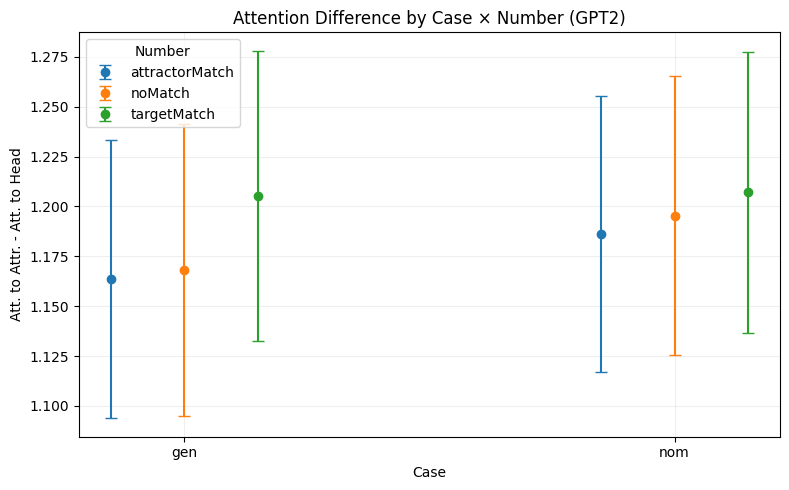

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("turkish_gpt2_attention_output.csv")

# Compute mean + SE for Case × Number
stats = df.groupby(["case", "number"])["attention_diff"].agg(["mean", "sem"]).reset_index()

cases = stats["case"].unique()
numbers = stats["number"].unique()

# x positions for each case
x = np.arange(len(cases))

# dodge width
dodge = 0.15

plt.figure(figsize=(8,5))

for i, num in enumerate(numbers):
    sub = stats[stats["number"] == num]

    # Shift x positions for dodging
    x_positions = x + (i - (len(numbers)-1)/2) * dodge

    plt.errorbar(
        x_positions,
        sub["mean"],
        yerr=sub["sem"],
        fmt="o",
        capsize=4,
        label=f"{num}"
    )

plt.xticks(x, cases)
plt.xlabel("Case")
plt.ylabel("Att. to Attr. - Att. to Head")
plt.title("Attention Difference by Case × Number (GPT2)")
plt.legend(title="Number")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


## BERT

In [ ]:
model_name = "dbmdz/bert-base-turkish-cased"
config = AutoConfig.from_pretrained(model_name)
config.output_attentions = True

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, config=config)
model.eval()

df = pd.read_csv("target_model_input.csv")

def get_token_span(word, tokens):
    word = word.lower().strip(".,’'")
    span = []
    pointer = 0
    for i, token in enumerate(tokens):
        clean = token.replace("##", "").lower().lstrip("▁")
        if word[pointer:].startswith(clean):
            span.append(i)
            pointer += len(clean)
        if pointer >= len(word):
            break
    return span

def extract_bert_attention_from_df(df, layer=BERT_LAYER, attn_head=BERT_HEAD):
    rows = []

    for _, row in df.iterrows():
        sentence = row["Sentence"]
        words = sentence.strip(".").split()
        if len(words) < 3:
            print(f"[SKIP] Too short: {sentence}")
            continue

        attractor = words[0]
        head = words[1]
        verb = words[-1]

        inputs = tokenizer(sentence, return_tensors="pt")
        tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

        att_span = get_token_span(attractor, tokens)
        head_span = get_token_span(head, tokens)
        verb_span = get_token_span(verb, tokens)

        if not att_span or not head_span or not verb_span:
            print(f"[SKIP] No span found in: {sentence}")
            continue

        with torch.no_grad():
            outputs = model(**inputs, output_attentions=True)
            attentions = outputs.attentions

        attn_matrix = attentions[layer][0, attn_head]

        attn_to_att = attn_matrix[verb_span][:, att_span].sum().item()
        attn_to_head = attn_matrix[verb_span][:, head_span].sum().item()

        rows.append({
            "item": row["Item"],
            "sentence": sentence,
            "case": row["Case"],
            "number": row["Number"],
            #"head_num": row["head_num"],
            #"attr_num": row["attr_num"],
            #"verb_num": row["verb_num"],
            "attention_to_attractor": attn_to_att,
            "attention_to_head": attn_to_head,
            "attractor_tokens": [tokens[i] for i in att_span],
            "head_tokens": [tokens[i] for i in head_span],
            "verb_tokens": [tokens[i] for i in verb_span],
        })

    return pd.DataFrame(rows)

turkish_bert_df = extract_bert_attention_from_df(df)
print(turkish_bert_df[["sentence", "attention_to_attractor", "attention_to_head"]])

turkish_bert_df.to_csv("turkish_bert_attention_verb_to_nouns.csv", index=False)


KeyboardInterrupt: 

In [2]:
import pandas as pd
df = pd.read_csv("turkish_bert_attention_verb_to_nouns.csv")

# Compute mean + SE for Case × Number
stats = df.groupby(["case", "number"])["attention_diff"].agg(["mean", "sem"]).reset_index()

cases = stats["case"].unique()
numbers = stats["number"].unique()

# x positions for each case
x = np.arange(len(cases))

# dodge width
dodge = 0.15

plt.figure(figsize=(8,5))

for i, num in enumerate(numbers):
    sub = stats[stats["number"] == num]

    # Shift x positions for dodging
    x_positions = x + (i - (len(numbers)-1)/2) * dodge

    plt.errorbar(
        x_positions,
        sub["mean"],
        yerr=sub["sem"],
        fmt="o",
        capsize=4,
        label=f"{num}"
    )

plt.xticks(x, cases)
plt.xlabel("Case")
plt.ylabel("Att. to Attr. - Att. to Head")
plt.title("Attention Difference by Case × Number (BERT)")
plt.legend(title="Number")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'turkish_bert_attention_verb_to_nouns.csv'

In [ ]:
bert_df = turkish_bert_df[["item", "sentence", "condition", "head_num", "attr_num", "verb_num", "attention_to_attractor", "attention_to_head"]].copy()
bert_df["model"] = "bert"

gpt2_df_clean = turkish_gpt2_df[["item", "sentence", "condition", "head_num", "attr_num", "verb_num", "attention_to_attractor", "attention_to_head"]].copy()
gpt2_df_clean["model"] = "gpt2"

combined_df = pd.concat([bert_df, gpt2_df_clean], ignore_index=True)

print(combined_df)
combined_df.to_csv("combined_bert_gpt2_attention_turkish.csv", index=False)


    item                                           sentence    condition  \
0      1   yöneticilerin aşçısı mutfakta sürekli zıpladılar  condition_a   
1      1      yöneticilerin aşçısı mutfakta sürekli zıpladı  condition_b   
2      1     yöneticinin aşçısı mutfakta sürekli zıpladılar  condition_c   
3      1        yöneticinin aşçısı mutfakta sürekli zıpladı  condition_d   
4      2      öğrencilerin ablası sınıfta birden bayıldılar  condition_a   
..   ...                                                ...          ...   
615   37  Politikacının tercümanı toplantıdan sonra bird...  condition_d   
616   38  Mühendislerin işvereni yabancı bir ülkede kayb...  condition_a   
617   38  Mühendislerin işvereni yabancı bir ülkede kayb...  condition_b   
618   38  Mühendisin işvereni yabancı bir ülkede kaybold...  condition_c   
619   38    Mühendisin işvereni yabancı bir ülkede kayboldu  condition_d   

    head_num attr_num verb_num  attention_to_attractor  attention_to_head  \
0         

# Surprisal

## BERT

In [ ]:
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)
model.eval()

df = pd.read_csv("syn_llm.csv", header=None,
    names=["language", "item", "syncretic", "sentence", "condition", "head_num", "attr_num", "verb_num"])
df = df[df["language"] == "turkish"]

results = []

for _, row in df.iterrows():
    sentence = row["sentence"]
    words = sentence.strip(".").split()
    if len(words) < 3:
        print(f"[SKIP] Too short: {sentence}")
        continue

    verb = words[-1]
    masked_words = words[:-1] + ["[MASK]"]
    masked_sent = " ".join(masked_words)

    try:
        inputs = tokenizer(masked_sent, return_tensors="pt")
        mask_idx = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1].item()

        with torch.no_grad():
            logits = model(**inputs).logits  # [batch, seq, vocab]

        probs = F.softmax(logits, dim=-1)
        verb_id = tokenizer.convert_tokens_to_ids(verb)
        prob = probs[0, mask_idx, verb_id].item()

        surprisal = -torch.log2(torch.tensor(prob)).item()

        results.append({
            "item": row["item"],
            "sentence": sentence,
            "condition": row["condition"],
            "head_num": row["head_num"],
            "attr_num": row["attr_num"],
            "verb_num": row["verb_num"],
            "verb": verb,
            "surprisal": surprisal,
            "model": "bert"
        })

    except Exception as e:
        print(f"[SKIP] {sentence} — {e}")
        continue

bert_surprisal_df = pd.DataFrame(results)
print(bert_surprisal_df)

bert_surprisal_df.to_csv("bert_turkish_verb_surprisal.csv", index=False)

    item                                           sentence    condition  \
0      1   yöneticilerin aşçısı mutfakta sürekli zıpladılar  condition_a   
1      1      yöneticilerin aşçısı mutfakta sürekli zıpladı  condition_b   
2      1     yöneticinin aşçısı mutfakta sürekli zıpladılar  condition_c   
3      1        yöneticinin aşçısı mutfakta sürekli zıpladı  condition_d   
4      2      öğrencilerin ablası sınıfta birden bayıldılar  condition_a   
..   ...                                                ...          ...   
307   37  Politikacının tercümanı toplantıdan sonra bird...  condition_d   
308   38  Mühendislerin işvereni yabancı bir ülkede kayb...  condition_a   
309   38  Mühendislerin işvereni yabancı bir ülkede kayb...  condition_b   
310   38  Mühendisin işvereni yabancı bir ülkede kaybold...  condition_c   
311   38    Mühendisin işvereni yabancı bir ülkede kayboldu  condition_d   

    head_num attr_num verb_num         verb  surprisal model  
0         sg       pl   

## GPT

In [ ]:
model_name = "ytu-ce-cosmos/turkish-gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()

df = pd.read_csv("syn_llm.csv", header=None,
    names=["language", "item", "syncretic", "sentence", "condition", "head_num", "attr_num", "verb_num"])
df = df[df["language"] == "turkish"]

results = []

for _, row in df.iterrows():
    sentence = row["sentence"]
    try:
        # Tokenize
        inputs = tokenizer(sentence, return_tensors="pt")
        input_ids = inputs["input_ids"]

        with torch.no_grad():
            logits = model(**inputs).logits

        probs = F.softmax(logits, dim=-1)
        next_token_probs = probs[0, :-1, :]
        true_next_tokens = input_ids[0, 1:]

        surprisals = -torch.log2(next_token_probs[torch.arange(len(true_next_tokens)), true_next_tokens])

        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

        for tok, s in reversed(list(zip(tokens[1:], surprisals.tolist()))):
            clean = tok.replace("Ġ", "").replace("▁", "").strip().lower()
            if clean and clean not in [".", ",", ";", "!", "?"]:
                results.append({
                    "item": row["item"],
                    "sentence": sentence,
                    "condition": row["condition"],
                    "head_num": row["head_num"],
                    "attr_num": row["attr_num"],
                    "verb_num": row["verb_num"],
                    "token": tok,
                    "surprisal": s,
                    "model": "gpt2"
                })
                break
        else:
            print(f"[SKIP] No content token found: {sentence}")

    except Exception as e:
        print(f"[SKIP] {sentence} — {e}")
        continue

gpt2_surprisal_df = pd.DataFrame(results)
print(gpt2_surprisal_df)

gpt2_surprisal_df.to_csv("gpt2_turkish_verb_surprisal.csv", index=False)


    item                                           sentence    condition  \
0      1   yöneticilerin aşçısı mutfakta sürekli zıpladılar  condition_a   
1      1      yöneticilerin aşçısı mutfakta sürekli zıpladı  condition_b   
2      1     yöneticinin aşçısı mutfakta sürekli zıpladılar  condition_c   
3      1        yöneticinin aşçısı mutfakta sürekli zıpladı  condition_d   
4      2      öğrencilerin ablası sınıfta birden bayıldılar  condition_a   
..   ...                                                ...          ...   
307   37  Politikacının tercümanı toplantıdan sonra bird...  condition_d   
308   38  Mühendislerin işvereni yabancı bir ülkede kayb...  condition_a   
309   38  Mühendislerin işvereni yabancı bir ülkede kayb...  condition_b   
310   38  Mühendisin işvereni yabancı bir ülkede kaybold...  condition_c   
311   38    Mühendisin işvereni yabancı bir ülkede kayboldu  condition_d   

    head_num attr_num verb_num      token  surprisal model  
0         sg       pl     

In [ ]:
import numpy as np

bert_surprisal_df["surprisal"] = bert_surprisal_df["surprisal"] / np.log(2)
gpt2_surprisal_df["surprisal"] = -gpt2_surprisal_df["surprisal"]
gpt2_surprisal_df["surprisal"] = gpt2_surprisal_df["surprisal"] / np.log(2)
surp_combined_df = pd.concat([bert_surprisal_df, gpt2_surprisal_df], ignore_index=True)
surp_combined_df.to_csv("turkish_bert_gpt2_combined_surprisal.csv", index=False)